<a href="https://colab.research.google.com/github/geek0075/fellowship/blob/main/fellowship_trec50_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Question Classification with TREC-50 Dataset**

Text classification algorithms are at the heart of a variety of software systems that process text data at scale. Email software uses text classification to determine whether incoming mail is sent to the inbox or filtered into the spam folder. Discussion forums use text classification to determine whether comments should be flagged as inappropriate.

These are two examples of topic classification, categorizing a text document into one of a predefined set of topics. In many topic classification problems, this categorization is based primarily on keywords in the text.

This notebook is based on the Experimental Data for Text Classification available online at https://cogcomp.seas.upenn.edu/Data/QA/QC/. In particular this notebook uses the Training Set 5 (5500 labeled questions) and the Test Set: TREC-10 questions, both available on that website listed above.

**Training Set**

The Training Set consists of 5500 labeled examples of the following form:
1.   LOC:state Which two states enclose Chesapeake Bay ?
2.   ABBR:exp What does the abbreviation AIDS stand for ?
3.   NUM:count How many points make up a perfect fivepin bowling score ?
4.   NUM:count How many Community Chest cards are there in Monopoly ?
5.   DESC:desc What do Mormons believe ?

Where each of the LOC:state, ABBR:exp, NUM:count, etc, constitute the fine-grained label and everything following that to the end of the line constitute the question. So for example 1, above, 'LOC:state' is the fine-grained label, while 'Which two states enclose Chesapeake Bay ?' is the question.

**Validation Set**

In this notebook, the Training Set described above is divided into a Training Set of 80% of the Original Training Set while the rest 20% is used for Validation Set during model Training.

**Testing Set**

The Testing Set consists of 500 labeled examples of exactly the same kind described above for the Training Set:
1.   NUM:dist How far is it from Denver to Aspen ?
2.   LOC:city What county is Modesto , California in ?
3.   HUM:desc Who was Galileo ?
4.   DESC:def What is an atom ?
5.   NUM:date When did Hawaii become a state ?

Where each of the NUM:dist, LOC:city, HUM:desc, etc, constitute the fine-grained label and everything following that to the end of the line constitute the question. So for example 1, above, 'NUM:dist' is the fine-grained label, while 'How far is it from Denver to Aspen ?' is the question.

The Testing Set is used purely for prediction and thus serves as a set of previously unseen examples. The labels on the Testing Set are used to compute an Accuracy figure for the Trained Classifier during prediction.

**Labels**

In this notebook, our classification will be based on the following 6 classes of labels:
1.   ABBR
2.   ENTY
3.   HUM
4.   NUM
5.   LOC
6.   DESC

**Load Python Packages**

In [1]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
import time

from torch.utils.data import Dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Define Python Function for Loading Data for Exploratory Data Analysis**

In [2]:
def load_data(seed=123):
    df = pd.read_csv('/content/drive/MyDrive/fellowship/trec-data/train_5500.csv')
    X = df['question']
    y = df['class'] - 1
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
    train_texts = X_train.tolist()
    train_labels = y_train.tolist()
    val_texts = X_val.tolist()
    val_labels = y_val.tolist()
    df_test = pd.read_csv('/content/drive/MyDrive/fellowship/trec-data/trec_10.csv')
    X_test = df_test['question']
    y_test = df_test['class'] - 1
    test_texts = X_test.tolist()
    test_labels = y_test.tolist()
    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)
    return ((train_texts, np.array(train_labels)), (val_texts, np.array(val_labels)), (test_texts, np.array(test_labels)))

**Load the Data for Exploratory Data Analysis**

In [3]:
data = load_data()

**Define Python Function for finding Number of Unique Labels**

In [4]:
def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes

**Define Python Function for finding Number of Words per Example**

In [5]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

**Define Python Function for plotting Frequency Distribution of n-grams**

In [6]:
def plot_frequency_distribution_of_ngrams(sample_texts, ngram_range=(1, 2), num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
        'ngram_range': (1, 1),
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names_out())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

**Define Python Function for plotting Example Length distribution**

In [7]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

**Define Python Function for plotting Class distribution of Example labels**

In [8]:
def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

**Extract Raw Train Texts and Train Labels in preparation for Exploratory Data Analysis**

In [9]:
(train_texts, train_labels), _, _ = data

**Compute Median Words Per Example as part of Exploratory Data Analysis**

In [10]:
median_words = get_num_words_per_sample(train_texts)
print('median_words per sample = {0}'.format(median_words))

median_words per sample = 10.0


**Compute Number of Classes as part of Exploratory Data Analysis**

In [11]:
num_classes = get_num_classes(train_labels.tolist())
print('num_classes = {0}'.format(num_classes))

num_classes = 6


**Plot Example Length Distribution as part of Exploratory Data Analysis**

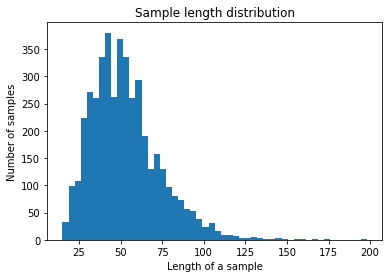

In [12]:
plot_sample_length_distribution(train_texts)

**Plot Example Label Class Distribution as part of Exploratory Data Analysis**

Here you can see that there is an imbalance in the Label Class distribution for Class 0 (ABBR).

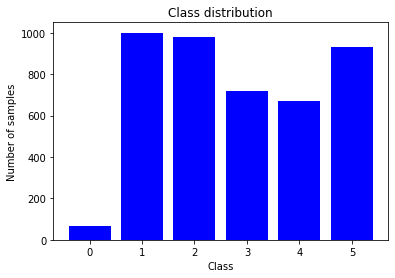

In [13]:
plot_class_distribution(train_labels.tolist())

**Plot Frequency Distribution of n-grams as part of Exploratory Data Analysis**

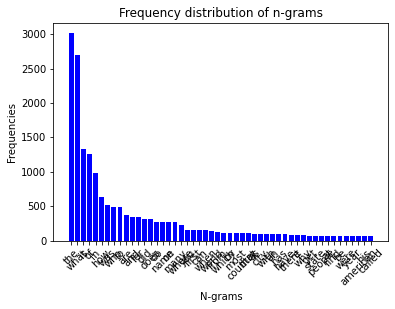

In [14]:
plot_frequency_distribution_of_ngrams(train_texts, ngram_range=(1, 2), num_ngrams=50)

**Choose a Model**

At this point, we have assembled our dataset and gained insights into the key characteristics of our data through the process of exploratory data analysis.

Next, based on the metrics we gathered in exploratory data analysis, we should think about which classification model we should use.

This means asking questions such as, 

1.   “How do we present the text data to an algorithm that expects numeric input?” (this is called data preprocessing and vectorization), 
2.   “What type of model should we use?”, 
3.   “What configuration parameters should we use for our model?”, 

etc.

**Algorithm for Data Preparation and Model Building**

1.   Calculate the number of samples/number of words per sample ratio.
2.   If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them:
     1.   Split the samples into word n-grams; convert the n-grams into vectors.
     2.   Score the importance of the vectors and then select the top 20K using the scores.
     3.   Build an MLP model.
3.   If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them:
     1.   Split the samples into words; select the top 20K words based on their frequency.
     2.   Convert the samples into word sequence vectors.
     3.   If the original number of samples/number of words per sample ratio is less than 15K, using a fine-tuned pre-trained embedding with the sepCNN model will likely provide the best results.
4.   Measure the model performance with different hyperparameter values to find the best model configuration for the dataset.

This algorithm answers two key questions:

1.   Which learning algorithm or model should we use?
2.   How should we prepare the data to efficiently learn the relationship between text and label?

The answer to the second question depends on the answer to the first question; the way we preprocess data to be fed into a model will depend on what model we choose. Models can be broadly classified into two categories: those that use word ordering information (sequence models), and ones that just see text as “bags” (sets) of words (n-gram models). Types of sequence models include convolutional neural networks (CNNs), recurrent neural networks (RNNs), and their variations. Types of n-gram models include logistic regression, simple multi- layer perceptrons (MLPs, or fully-connected neural networks), gradient boosted trees and support vector machines.

In the case of our dataset, the samples/words-per-sample ratio is ~550. This means that we will create a MLP model.

**Text Classification MLP Model**

The model is composed of the nn.EmbeddingBag layer plus a linear layer for the classification purpose. nn.EmbeddingBag with the default mode of “mean” computes the mean value of a “bag” of embeddings. Although the text entries here have different lengths, nn.EmbeddingBag module requires no padding here since the text lengths are saved in offsets.

Additionally, since nn.EmbeddingBag accumulates the average across the embeddings on the fly, nn.EmbeddingBag can enhance the performance and memory efficiency to process a sequence of tensors.

In [15]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

**Trec Custom PyTorch Dataset Class**

In [16]:
class TrecDataset(Dataset):

    def __init__(self, csv_file):
        self.trec_frame = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.trec_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        label = self.trec_frame.iloc[idx, 0]
        question = self.trec_frame.iloc[idx, 2]
        return label, question

**Data Preparation**

Before our data can be fed to a model, it needs to be transformed to a format the model can understand.

First, the data samples that we have gathered may be in a specific order. We do not want any information associated with the ordering of samples to influence the relationship between texts and labels. For example, if a dataset is sorted by class and is then split into training/validation sets, these sets will not be representative of the overall distribution of data.

A simple best practice to ensure the model is not affected by data order is to always shuffle the data before doing anything else. If your data is already split into training and validation sets, make sure to transform your validation data the same way you transform your training data. If you don’t already have separate training and validation sets, you can split the samples after shuffling; it’s typical to use 80% of the samples for training and 20% for validation.

Second, machine learning algorithms take numbers as inputs. This means that we will need to convert the texts into numerical vectors. There are two steps to this process:

1.   Tokenization: Divide the texts into words or smaller sub-texts, which will enable good generalization of relationship between the texts and the labels. This determines the “vocabulary” of the dataset (set of unique tokens present in the data).

2.   Vectorization: Define a good numerical measure to characterize these texts.

**N-gram vectors**

In an n-gram vector, text is represented as a collection of unique n-grams: groups of n adjacent tokens (typically, words). Consider the text The mouse ran up the clock. Here, the word unigrams (n = 1) are ['the', 'mouse', 'ran', 'up', 'clock'], the word bigrams (n = 2) are ['the mouse', 'mouse ran', 'ran up', 'up the', 'the clock'], and so on.

With n-gram vector representation, we discard a lot of information about word order and grammar (at best, we can maintain some partial ordering information when n > 1). This is called a bag-of-words approach. This representation is used in conjunction with models that don’t take ordering into account, such as logistic regression, multi-layer perceptrons, gradient boosting machines, support vector machines.

In [17]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

train_iter = TrecDataset(csv_file='/content/drive/MyDrive/fellowship/trec-data/train_5500.csv')
test_iter = TrecDataset(csv_file='/content/drive/MyDrive/fellowship/trec-data/trec_10.csv')
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

# Hyperparameters
EPOCHS = 10 # epoch
# LR = 5
LR = 5  # learning rate
# BATCH_SIZE = 64
BATCH_SIZE = 8 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

**Define Python Function to Train the Model**

In [18]:
def train(dataloader, epoch):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

**Define Python Function to Evaluate the Model**

In [19]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

**Split the Dataset**

In [20]:
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.80)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

**Train the Model**

In [21]:
total_accu = None
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader, epoch)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid accuracy {:8.3f} '.format(epoch, time.time() - epoch_start_time, accu_val))
    print('-' * 59)

| epoch   1 |   500/  546 batches | accuracy    0.583
-----------------------------------------------------------
| end of epoch   1 | time:  2.32s | valid accuracy    0.702 
-----------------------------------------------------------
| epoch   2 |   500/  546 batches | accuracy    0.762
-----------------------------------------------------------
| end of epoch   2 | time:  1.73s | valid accuracy    0.731 
-----------------------------------------------------------
| epoch   3 |   500/  546 batches | accuracy    0.833
-----------------------------------------------------------
| end of epoch   3 | time:  0.78s | valid accuracy    0.787 
-----------------------------------------------------------
| epoch   4 |   500/  546 batches | accuracy    0.886
-----------------------------------------------------------
| end of epoch   4 | time:  0.76s | valid accuracy    0.789 
-----------------------------------------------------------
| epoch   5 |   500/  546 batches | accuracy    0.921
------

**Evaluate the model on the Test Data Set**

In [22]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.860


**References**

1.    https://developers.google.com/machine-learning/guides/text-classification
2.    https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
3.    https://cogcomp.seas.upenn.edu/Data/QA/QC/